# Thanker Experiment Report Feb 2020
[J. Nathan Matias](https://natematias.com), [Citizens and Technology Lab](https://citizensandtech.org)


### References
* [Experiment Plan: The Effect of Sending Thanks on Wikipedia](https://osf.io/e5r3q/)


# Analysis Code

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)
Warning message in install.packages("ggpubr"):
“installation of package ‘ggpubr’ had non-zero exit status”

In [998]:
## Load Libraries
library(ggplot2)
library(ggpubr)  # contains ggarrange
library(gmodels) # contains CrossTable
library(estimatr)
library(corrplot)
library(lme4)
library(broom)
library(knitr)
library(lmerTest)
library(texreg)

## Set visual style
catpalette <- c("#333333", "#ea5324", "#005073", "#7D868C", "#BDBBBB", "#F2F2F2","#F6F2EB")
cat.theme <-  theme_bw() +
              theme(plot.title = element_text(size=11.5, face="bold", color=catpalette[3]),
                    axis.title.x =element_text(size=10, hjust = -0.01, color = catpalette[1]),
                    axis.title.y =element_text(size=10, color = catpalette[1]),
                    panel.background = element_rect(fill=catpalette[6]))
options(repr.plot.width=6, repr.plot.height=4.5)

### Load Experiment Results Data

In [709]:
data.dir = "~/Tresors/CivilServant/projects/wikipedia-integration/gratitude-study/Data Drills/thanker_hardlaunch/post_experiment_analysis/"
filename = "all-pre_and_post_treatment_vars_with_post_survey_R_columns.csv"
participant <- read.csv(paste(data.dir, filename, sep=""))

## 38 participants accessed & used the system before the experiment started
## we have assigned them randomization.block.id = -1 and omitted them from the analysis
participant <- subset(participant, randomization.block.id!=-1)

participant$complier <- participant$complier == "True"
participant$complier.int <- as.integer(participant$complier)
participant$complier.app.int <- as.integer(participant$complier.app=="True")
participant$complier.app.logged.in.int <- as.integer(participant$complier.app.logged.in=="True")
participant$TREAT <- participant$randomization.arm

## inclusive compliers are participants that:
### among control, logged in
### among treatment, completed the task
participant$complier.app.inclusive <- (participant$T==1 & participant$complier.app=="True") | 
                                         (participant$TREAT==0 & participant$complier.app.logged.in=="True")


participant$diff.labor.hours <- participant$labor.hours.56.post.treatment - participant$labor.hours.56.pre.treatment

participant$diff.newcomer.capability <- participant$post.newcomer.capability - participant$pre.newcomer.capability
participant$diff.newcomer.intent <- participant$post.newcomer.intent - participant$pre.newcomer.intent

participant$diff.thanks.sent <- participant$wikithanks.56.post.treatment - participant$wikithanks.56.pre.treatment

participant$diff.emotionally.draining <- participant$post.emotionally.draining - participant$pre.emotionally.draining
participant$diff.monitoring.damaging.content <- participant$post.monitoring.damaging.content - participant$pre.monitoring.damaging.content
participant$diff.mentoring <- participant$post.mentoring - participant$pre.mentoring

## ZEROED OUT SURVEY PREDICTORS
participant$pre.emotionally.draining.zeroed <- participant$pre.emotionally.draining-3
participant$previous.positive.feeling.zeroed <- participant$previous.positive.feeling-3

## individual participants that complied with the app
behavioral.compliers.exclusive <- subset(participant, complier.app!="False")
behavioral.compliers.inclusive <- subset(participant, complier.app.inclusive)
behavioral.compliers.login <- subset(participant, complier.app.logged.in!="False")

## individual participants that complied with the survey
survey.compliers <- subset(participant, complier)

## dataframe with a sum of how many block members complied
behavioral.block.compliance <- aggregate(participant[c('complier.app.logged.in.int')], by=list(participant$randomization.block.id), FUN=sum)
survey.block.compliance <- aggregate(participant[c('complier.int')], by=list(participant$randomization.block.id), FUN=sum)

## accounts in blocks where every block participant complied with the app
behavioral.block.compliers <- subset(participant, randomization.block.id %in% subset(behavioral.block.compliance, complier.app.logged.in.int==1)$Group.1)

## accounts in blocks where every block participant complied with the survey
survey.block.compliers <- subset(participant, randomization.block.id %in% subset(survey.block.compliance, complier.int==2)$Group.1)

### Load Full Initial Survey Taking Group

In [710]:
data.path <- "~/Tresors/CivilServant/projects/wikipedia-integration/gratitude-study/Data Drills/thanker_hardlaunch/historical_survey_merged"
de.filename = "de-merged-20190729.csv"
ar.filename = "ar-merged-20190729.csv"
fa.filename = "fa-merged-20190729.csv"
pl.filename = "pl-merged-20190729.csv"
thankers.df <- rbind(read.csv(file.path(data.path,de.filename), sep=","),
                     read.csv(file.path(data.path,ar.filename), sep=","),
                     read.csv(file.path(data.path,pl.filename), sep=","))
fa.thankers.df <- read.csv(file.path(data.path,fa.filename), sep=",")


thankers.df <- rbind(thankers.df, 
                 fa.thankers.df[colnames(thankers.df)])
thankers.df$pre_experienced_capability <- thankers.df$trust_2
thankers.df$pre_experienced_intent <- thankers.df$trust_4
thankers.df$prop_support_84_pre_treatment <- thankers.df$support_talk_84_pre_treatment / (thankers.df$total_edits_84_pre_treatment + 1)
thankers.df$prop_reverts_84_pre_treatment <- thankers.df$num_reverts_84_pre_treatment / (thankers.df$total_edits_84_pre_treatment + 1)
thankers.df$prop_support_84_minus_prop_reverts_84_pre_treatment <- thankers.df$prop_support_84_pre_treatment  - thankers.df$prop_reverts_84_pre_treatment

# Introduction Analysis

### Full Group Count

In [711]:
nrow(thankers.df)

[1] 447

### Who Participated in the Study

In [712]:
print(paste(nrow(participant), "volunteers"))
print(paste(nrow(subset(participant, complier.app.logged.in=="True")), "accounts logged in"))
print(paste(nrow(subset(participant, complier.app.inclusive)), "accounts in the 'inclusive' app sample"))
print(paste(nrow(subset(participant, complier.app.int==1)), "accounts in the 'exclusive' app sample"))
print(paste(nrow(behavioral.block.compliers), "behavioral block compliers (logged in)"))
print(paste(nrow(subset(participant, complier.survey=="True")), "accounts completed post-survey"))
print(paste(sum(participant$num.thank.actions, na.rm=TRUE), "thanks sent"))
print(paste(sum(as.integer(participant$num.thank.actions > 0), na.rm=TRUE), "accounts sent thanks"))
print(paste(sum(participant$num.thankees.skipped, na.rm=TRUE), "accounts skipped"))

[1] "400 volunteers"
[1] "238 accounts logged in"
[1] "205 accounts in the 'inclusive' app sample"
[1] "154 accounts in the 'exclusive' app sample"
[1] "172 behavioral block compliers (logged in)"
[1] "140 accounts completed post-survey"
[1] "342 thanks sent"
[1] "89 accounts sent thanks"
[1] "489 accounts skipped"


In [713]:
summary(participant$lang)

ar  de  fa  pl 
  0 286  52  62

[1] "Year joined"


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  0.000   5.000   9.000   8.498  12.000  17.000 

[1] "Edits in the 56 days before treatment"


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   0.00    8.75   53.50  194.56  210.00 4109.00 

[1] "Labor Hours in the 56 days before treatment"


    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
  0.0000   0.9106   6.4926  22.1485  27.7571 299.2500 

[1] "Reverts in the 56 days before treatment"


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
    0.0     0.0     1.0    12.2     5.0   470.0 

   Mode   FALSE    TRUE 
logical     182     218 

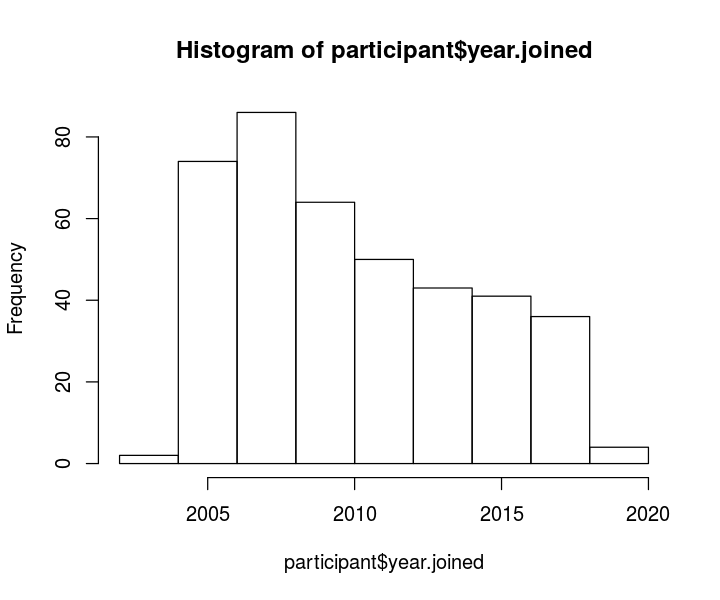

In [714]:
print("Year joined")
summary(2019-participant$year.joined)
hist(participant$year.joined)
print("Edits in the 56 days before treatment")
summary(participant$total.edits.56.pre.treatment)

print("Labor Hours in the 56 days before treatment")
summary(participant$labor.hours.56.pre.treatment)


print("Reverts in the 56 days before treatment")
summary(participant$num.reverts.56.pre.treatment)
summary(participant$num.reverts.56.pre.treatment>0)

## The False Dilemma Between Mentoring and Monitoring

### Baseline Rates of Monitoring and Mentoring, Comparing Rates

In [715]:
summary((participant$pre.mentoring))
summary((participant$pre.monitoring))
summary(participant$pre.mentoring>3)
summary(participant$pre.monitoring>3)

t.test(participant$pre.mentoring, participant$pre.monitoring)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  1.000   1.000   1.000   1.573   2.000   5.000 

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  1.000   1.000   2.000   2.337   3.000   5.000 

   Mode   FALSE    TRUE 
logical     380      20 

   Mode   FALSE    TRUE 
logical     326      74 


	Welch Two Sample t-test

data:  participant$pre.mentoring and participant$pre.monitoring
t = -10.769, df = 752.71, p-value < 2.2e-16
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -0.9044501 -0.6255499
sample estimates:
mean of x mean of y 
   1.5725    2.3375 


In [716]:
t.test(subset(participant, participant$pre.monitoring>3)$pre.mentoring,
       subset(participant, participant$pre.monitoring<=3)$pre.mentoring)


	Welch Two Sample t-test

data:  subset(participant, participant$pre.monitoring > 3)$pre.mentoring and subset(participant, participant$pre.monitoring <= 3)$pre.mentoring
t = 4.7262, df = 87.808, p-value = 8.642e-06
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 0.3808416 0.9335342
sample estimates:
mean of x mean of y 
 2.108108  1.450920 


### Correlations Between Supportive Activity, Monitoring Activity, and Mentoring Activity

In [892]:
catpalette

[1] "#333333" "#ea5324" "#005073" "#7D868C" "#BDBBBB" "#F2F2F2" "#F6F2EB"

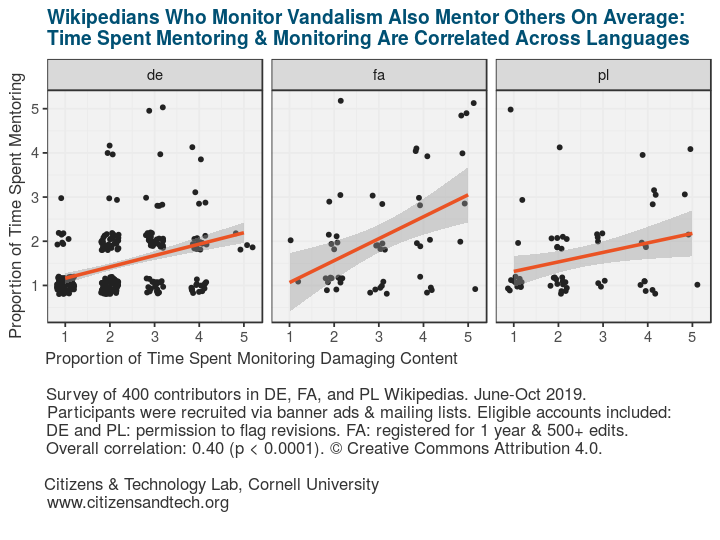

In [910]:
#https://www.brooklynintegers.com/int/1528119887/
set.seed(1528119887)

ggplot(participant, aes(pre.monitoring.damaging.content, pre.mentoring)) +
    geom_jitter(width=0.2, height=0.2, size=1, color ="#222222") +
    geom_smooth(method='lm', color=catpalette[2]) + 
    cat.theme +
    facet_grid(. ~ lang) +
    ylab("Proportion of Time Spent Mentoring") +
    ggtitle(paste("Wikipedians Who Monitor Vandalism Also Mentor Others On Average:", "\n",
                  "Time Spent Mentoring & Monitoring Are Correlated Across Languages",sep="")) +
    xlab(paste("Proportion of Time Spent Monitoring Damaging Content", "\n\n",
               "Survey of ", nrow(participant),  " contributors in DE, FA, and PL Wikipedias. June-Oct 2019.", "\n",
               "Participants were recruited via banner ads & mailing lists. Eligible accounts included:", "\n",
               "DE and PL: permission to flag revisions. FA: registered for 1 year & 500+ edits.", "\n",
               "Overall correlation: ", sprintf("%0.2f", cor(participant$pre.monitoring.damaging.content, participant$pre.mentoring)),
               " (p < 0.0001). ", "© Creative Commons Attribution 4.0.", "\n",
               "\n",
               "Citizens & Technology Lab, Cornell University", "\n",
               " www.citizensandtech.org", "\n",               
               sep=""))

In [575]:
pre.mentoring.monitoring.corr <- cor.test(participant$pre.mentoring,  participant$pre.monitoring.damaging.content)
pre.mentoring.monitoring.corr


	Pearson's product-moment correlation

data:  participant$pre.mentoring and participant$pre.monitoring.damaging.content
t = 8.7445, df = 398, p-value < 2.2e-16
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 0.3158305 0.4805847
sample estimates:
      cor 
0.4014502 


In [460]:
pre.supportive.monitoring <- cor.test(participant$previous.supportive.actions, participant$pre.monitoring.damaging.content)
pre.supportive.mentoring <- cor.test(participant$previous.supportive.actions, participant$pre.mentoring)
pre.supportive.monitoring
pre.supportive.mentoring


	Pearson's product-moment correlation

data:  participant$previous.supportive.actions and participant$pre.monitoring.damaging.content
t = 4.8154, df = 398, p-value = 2.091e-06
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 0.1398024 0.3252075
sample estimates:
      cor 
0.2346377 



	Pearson's product-moment correlation

data:  participant$previous.supportive.actions and participant$pre.mentoring
t = 5.4318, df = 398, p-value = 9.733e-08
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 0.1690091 0.3516997
sample estimates:
      cor 
0.2627073 


In [461]:
summary(participant$num.reverts.56.pre.treatment)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
    0.0     0.0     1.0    12.2     5.0   470.0 

In [462]:
pre.supportive.reverting <- cor.test(participant$previous.supportive.actions, 
                                     participant$num.reverts.56.pre.treatment)
pre.supportive.reverting
pre.mentoring.reverting <- cor.test(participant$pre.mentoring, 
                                     log1p(participant$num.reverts.56.pre.treatment))
pre.mentoring.reverting


	Pearson's product-moment correlation

data:  participant$previous.supportive.actions and participant$num.reverts.56.pre.treatment
t = 13.587, df = 398, p-value < 2.2e-16
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 0.4920253 0.6263972
sample estimates:
      cor 
0.5629196 



	Pearson's product-moment correlation

data:  participant$pre.mentoring and log1p(participant$num.reverts.56.pre.treatment)
t = 5.4775, df = 398, p-value = 7.66e-08
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 0.1711575 0.3536369
sample estimates:
      cor 
0.2647659 


In [463]:
## RELATIONSHIP BETWEEN MENTORING AND REVERTS
summary(pre.mentoring.reverts.lm <- lm(log1p(num.reverts.56.pre.treatment) ~ 
                                       log1p(total.edits.56.pre.treatment) + 
                                       pre.mentoring, 
                                       data=participant))


Call:
lm(formula = log1p(num.reverts.56.pre.treatment) ~ log1p(total.edits.56.pre.treatment) + 
    pre.mentoring, data = participant)

Residuals:
    Min      1Q  Median      3Q     Max 
-2.2313 -0.6221 -0.0114  0.5156  3.4486 

Coefficients:
                                    Estimate Std. Error t value Pr(>|t|)    
(Intercept)                         -1.08419    0.12422  -8.728  < 2e-16 ***
log1p(total.edits.56.pre.treatment)  0.47973    0.02399  19.998  < 2e-16 ***
pre.mentoring                        0.23608    0.05546   4.257 2.59e-05 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.9528 on 397 degrees of freedom
Multiple R-squared:  0.5368,	Adjusted R-squared:  0.5344 
F-statistic:   230 on 2 and 397 DF,  p-value: < 2.2e-16


In [916]:
# ggplot(participant, aes(pre.mentoring, log1p(num.reverts.56.pre.treatment))) +
#     geom_jitter(width=0.2, size=0.5, color="darkgray") +
#     cat.theme +
#     geom_smooth(method='lm', color="red") + 
#     facet_grid(. ~ lang)

In [465]:
## OMIT THE CHART RELATING SUPPORTIVE ACTIONS TO REVERTS
# ggplot(participant, aes(log1p(previous.supportive.actions), log1p(num.reverts.56.pre.treatment))) +
#     geom_point(size=0.5, color="darkgray") +
#     theme_bw() +
#     geom_smooth(method='lm', color="darkgreen") + 
#     facet_grid(. ~ lang)

### Feeling Positive and Feeling Emotionally Drained

In [466]:
summary(participant$previous.positive.feeling)
summary(factor(participant$previous.positive.feeling))

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  1.000   4.000   4.000   4.183   5.000   5.000 

1   2   3   4   5 
  3  16  53 161 167

In [467]:
summary(participant$pre.emotionally.draining)
summary(factor(participant$pre.emotionally.draining))

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  1.000   1.000   2.000   2.228   3.000   5.000 

1   2   3   4   5 
122 147  65  50  16


	Pearson's product-moment correlation

data:  participant$previous.positive.feeling and participant$pre.emotionally.draining
t = -5.1607, df = 398, p-value = 3.892e-07
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 -0.3401364 -0.1562214
sample estimates:
      cor 
-0.250437 



	Pearson's product-moment correlation

data:  participant$previous.positive.feeling and log1p(participant$previous.supportive.actions)
t = 2.0972, df = 398, p-value = 0.0366
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 0.006564428 0.200544751
sample estimates:
      cor 
0.1045489 


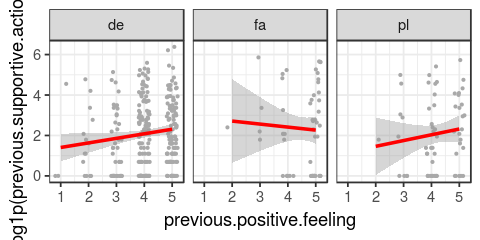

In [468]:
pre.positive.drained <- cor.test(participant$previous.positive.feeling, 
                                     participant$pre.emotionally.draining)
pre.positive.drained

pre.positive.support <- cor.test(participant$previous.positive.feeling, 
                                     log1p(participant$previous.supportive.actions))
pre.positive.support

ggplot(participant, aes(previous.positive.feeling, log1p(previous.supportive.actions))) +
    geom_jitter(width=0.2, size=0.5, color="darkgray") +
    theme_bw() +
    geom_smooth(method='lm', color="red") + 
    facet_grid(. ~ lang)


	Pearson's product-moment correlation

data:  participant$previous.positive.feeling and participant$pre.monitoring.damaging.content
t = 2.57, df = 398, p-value = 0.01053
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 0.03009138 0.22302388
sample estimates:
      cor 
0.1277661 


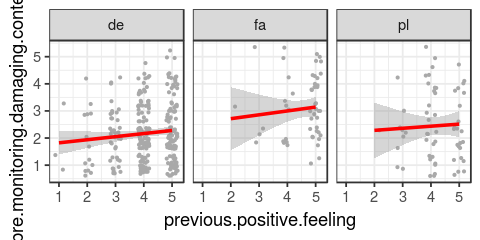

In [469]:
cor.test(participant$previous.positive.feeling, 
         participant$pre.monitoring.damaging.content)

ggplot(participant, aes(previous.positive.feeling, pre.monitoring.damaging.content)) +
    geom_jitter(width=0.2, size=0.5, color="darkgray") +
    theme_bw() +
    geom_smooth(method='lm', color="red") + 
    facet_grid(. ~ lang)


	Pearson's product-moment correlation

data:  participant$pre.emotionally.draining and participant$pre.monitoring.damaging.content
t = 3.9516, df = 398, p-value = 9.183e-05
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 0.09812003 0.28688841
sample estimates:
      cor 
0.1943024 


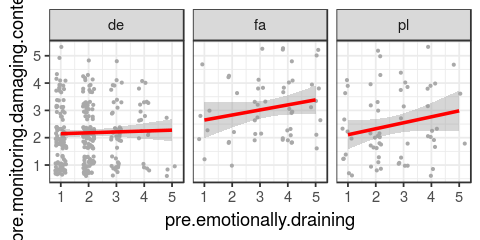

In [470]:
cor.test(participant$pre.emotionally.draining, 
         participant$pre.monitoring.damaging.content)

ggplot(participant, aes(pre.emotionally.draining, pre.monitoring.damaging.content)) +
    geom_jitter(width=0.2, size=0.5, color="darkgray") +
    theme_bw() +
    geom_smooth(method='lm', color="red") + 
    facet_grid(. ~ lang)

In [980]:
# corrplot(cor(participant[c("previous.positive.feeling", 
#                       "pre.mentoring",
#                       "pre.emotionally.draining",
#                       "pre.monitoring.damaging.content")]))


In [982]:
    screenreg(monitoring.positive.lm <- lm(pre.monitoring.damaging.content ~ 
           pre.emotionally.draining.zeroed + 
           previous.positive.feeling.zeroed +
           labor.hours.56.pre.treatment,
           data=subset(participant)),
       html.tag=FALSE,
       custom.model.names=c("Login"),
       custom.coef.names =c("(Intercept)", "Emotionally Drained", "Positive Feeling", "Labor Hours"),
       caption=paste("Factors Predicting Chance of Login", "<br/>",
                       "Survey of ", nrow(participant),  " contributors in DE, FA, and PL Wikipedias, June-Oct 2019.", "<br/>",
                       "Participants were recruited via banner ads & mailing lists.","<br/>",
                       "Eligible accounts included:",
                       "DE and PL: permission to flag revisions. FA: registered for 1 year & 500+ edits.", "<br/>", 
                       "© Creative Commons Attribution 4.0.", "\n",
                       "\n",
                       "Citizens & Technology Lab, Cornell University:",
                       " <a href=\"https://citizensandtech.org\">www.citizensandtech.org</a>",               
                       sep=""))

===============================
                     Login     
-------------------------------
(Intercept)            2.14 ***
                      (0.10)   
Emotionally Drained    0.23 ***
                      (0.05)   
Positive Feeling       0.21 ** 
                      (0.06)   
Labor Hours            0.01 ***
                      (0.00)   
-------------------------------
R^2                    0.10    
Adj. R^2               0.09    
Num. obs.            400       
RMSE                   1.07    
===============================
*** p < 0.001, ** p < 0.01, * p < 0.05

In [624]:
summary(factor(participant$complier.app.logged.in.int))

0   1 
162 238

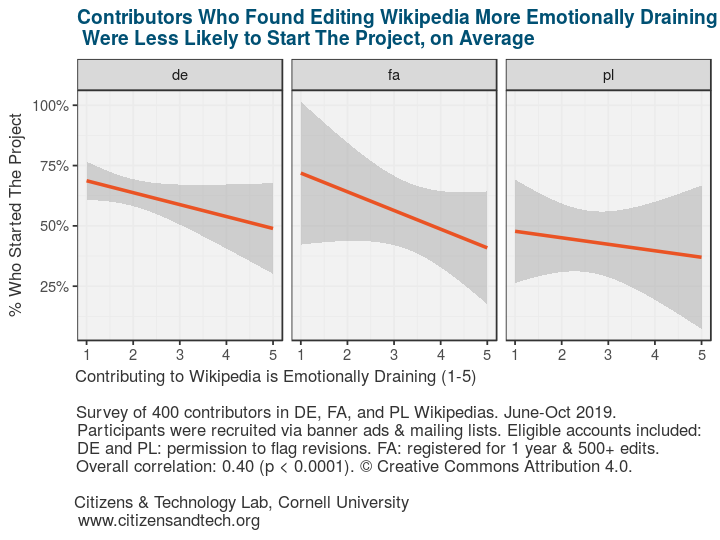

In [963]:
ggplot(participant, aes(pre.emotionally.draining, complier.app.logged.in.int)) +
    theme_bw() +
    geom_smooth(method='lm', color=catpalette[2]) + 
    scale_y_continuous(labels=scales::number_format(accuracy=1.0, scale=100, suffix="%")) +
    facet_grid(. ~ lang) +
    ylab("% Who Started The Project") +
    cat.theme + 
    ggtitle(paste("Contributors Who Found Editing Wikipedia More Emotionally Draining","\n",
                  "Were Less Likely to Start The Project, on Average")) +
    xlab(paste("Contributing to Wikipedia is Emotionally Draining (1-5)", "\n\n", 
               "Survey of ", nrow(participant),  " contributors in DE, FA, and PL Wikipedias. June-Oct 2019.", "\n",
               "Participants were recruited via banner ads & mailing lists. Eligible accounts included:", "\n",
               "DE and PL: permission to flag revisions. FA: registered for 1 year & 500+ edits.", "\n",
               "Overall correlation: ", sprintf("%0.2f", cor(participant$pre.monitoring.damaging.content, participant$pre.mentoring)),
               " (p < 0.0001). ", "© Creative Commons Attribution 4.0.", "\n",
               "\n",
               "Citizens & Technology Lab, Cornell University", "\n",
               " www.citizensandtech.org",
               sep=""))

In [ ]:
participant$pre.feel.positive

In [926]:
summary(lm(complier.app.logged.in.int ~ 
           pre.emotionally.draining.zeroed,
   data=participant))


Call:
lm(formula = complier.app.logged.in.int ~ pre.emotionally.draining.zeroed, 
    data = participant)

Residuals:
    Min      1Q  Median      3Q     Max 
-0.6699 -0.5478  0.3301  0.3911  0.5742 

Coefficients:
                                Estimate Std. Error t value Pr(>|t|)    
(Intercept)                      0.54785    0.02952   18.56   <2e-16 ***
pre.emotionally.draining.zeroed -0.06103    0.02157   -2.83   0.0049 ** 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.4872 on 398 degrees of freedom
Multiple R-squared:  0.01972,	Adjusted R-squared:  0.01726 
F-statistic: 8.007 on 1 and 398 DF,  p-value: 0.004896


### Views About newcomer Capability and Intent

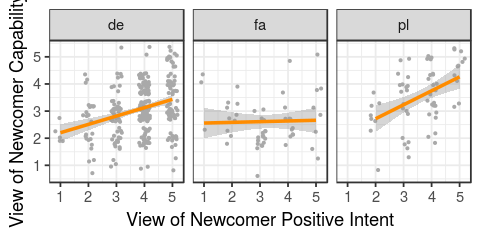

In [473]:
ggplot(participant, aes(pre.newcomer.intent, pre.newcomer.capability)) +
    geom_jitter(width=0.2, size=0.5, color="darkgray") +
    geom_smooth(method='lm', color="darkorange") + 
    theme_bw() +
    xlab("View of Newcomer Positive Intent") +
    ylab("View of Newcomer Capability") +
    facet_grid(. ~ lang)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  1.000   2.000   3.000   3.085   4.000   5.000 

1   2   3   4   5 
 14 100 155 100  31

Group.1,pre.newcomer.capability
de,3.069930
fa,2.615385
pl,3.548387


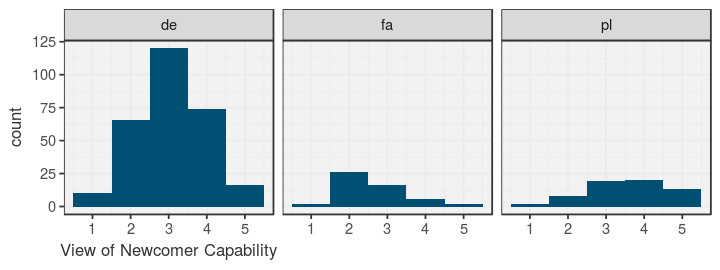

In [992]:
options(repr.plot.width=6, repr.plot.height=2.25)

summary(participant$pre.newcomer.capability)
summary(factor(participant$pre.newcomer.capability))

aggregate(participant[c("pre.newcomer.capability")],
          by=list(participant$lang), FUN=mean)

plot.newcomer.capability <- 
    ggplot(participant, aes(pre.newcomer.capability)) +
    geom_histogram(binwidth=1, fill=catpalette[3]) +
    cat.theme +
    xlab("View of Newcomer Capability") +
    facet_grid(. ~ lang)

plot.newcomer.capability

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  1.000   3.000   4.000   3.712   4.000   5.000 

1   2   3   4   5 
  8  42  97 163  90

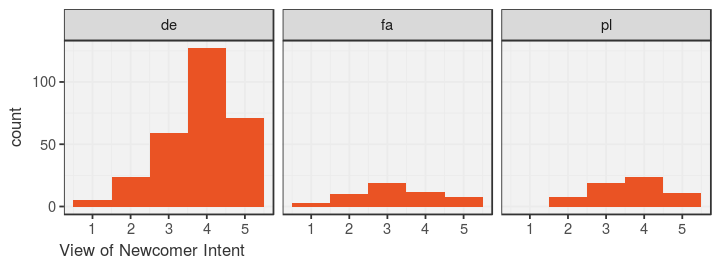

In [993]:
summary(participant$pre.newcomer.intent)
summary(factor(participant$pre.newcomer.intent))

plot.newcomer.intent <- ggplot(participant, aes(pre.newcomer.intent)) +
    geom_histogram(binwidth=1, fill=catpalette[2]) +
    cat.theme +
    xlab("View of Newcomer Intent") +
    facet_grid(. ~ lang)

plot.newcomer.intent

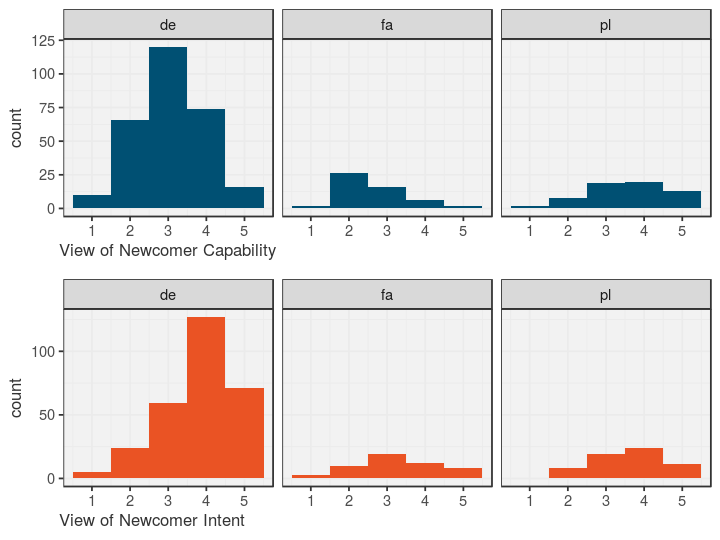

In [1002]:
ggarrange(plot.newcomer.capability, plot.newcomer.intent, ncol=1, nrow=2) +
    ggtitle("This is a Title")

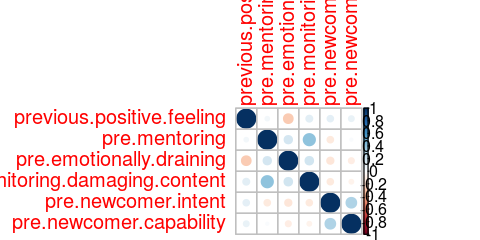

In [476]:
corrplot(cor(participant[c("previous.positive.feeling", 
                      "pre.mentoring",
                      "pre.emotionally.draining",
                      "pre.monitoring.damaging.content",
                      "pre.newcomer.intent",
                      "pre.newcomer.capability")]))

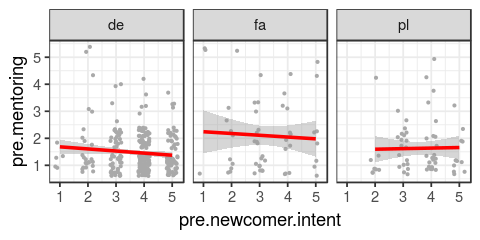

In [477]:
ggplot(participant, aes(pre.newcomer.intent, pre.mentoring)) +
    geom_jitter(width=0.2, size=0.5, color="darkgray") +
    theme_bw() +
    geom_smooth(method='lm', color="red") + 
    facet_grid(. ~ lang)

In [478]:
## DECIDING WHETHER TO SAY THAT PEOPLE WHO
## REPORTING DOING MORE MENTORING ALSO REPORT
## LOWER NEWCOMER INTENT, CONROLLING FOR CAPABILITY RATING
## IT PERSISTS AND BECOMES STRONGER AS YOU ADD MORE CONTROLS
## BUT IT APPEARS TO BE DRIVEN BY BETWEEN-LANGUAGE VARIATION
## NOT BY WITHIN-LANGUAGE VARIATION, SO I HAVE OMITTED IT
# summary(lmer(pre.newcomer.intent ~ 
#            pre.mentoring +
#            pre.newcomer.capability 
#            | lang, data=participant))

# The Effect of Thanking Others on Wikipedia

#### Effect on Socially Supportive Actions

In [587]:
nrow(behavioral.block.compliers)
difference_in_means(diff.supportive.actions ~ TREAT, 
                    blocks = randomization.block.id, data = behavioral.block.compliers)

[1] 172

Design:  Matched-pair 
       Estimate Std. Error    t value  Pr(>|t|)  CI Lower CI Upper DF
TREAT -2.976744   4.189459 -0.7105319 0.4793194 -11.30651 5.353023 85

In [586]:
# # LOWER BOUND (Gerber & Green 164-165)
difference_in_means(diff.supportive.actions ~ TREAT, 
                     data = behavioral.compliers.login)

Design:  Standard 
      Estimate Std. Error  t value  Pr(>|t|) CI Lower CI Upper       DF
TREAT 6.983047   6.461541 1.080709 0.2813695 -5.77288 19.73897 168.6401

In [562]:
# ## UPPER BOUND BOUND (Gerber & Green 164-165)
# lwr.behavior.compliers.login <- behavioral.compliers.login
# lwr.behavior.compliers.login[lwr.behavior.compliers.login$complier.app.int==0,]$TREAT <- 0


# difference_in_means(diff.supportive.actions ~ TREAT, 
#                     data = lwr.behavior.compliers.login)

#### Effect on Positive Feeling

In [590]:
difference_in_means(diff.positive.feeling ~ TREAT, data = survey.compliers)

Design:  Standard 
        Estimate Std. Error   t value   Pr(>|t|)   CI Lower    CI Upper
TREAT -0.2533248   0.117356 -2.158602 0.03273018 -0.4855139 -0.02113563
            DF
TREAT 129.1475

In [607]:
p.adjust(c(0.2813695,0.03273018),"holm")

[1] 0.28136950 0.06546036

In [696]:
#colnames(participant)